Data on confirmed COVID-19 cases in Scotland by Health board taken from the Web Archive [WayBackMachine](https://web.archive.org/web/*/https://www. gov.scot/coronavirus-covid-19/) capture of the Scottish Government published health board data published since 2020-03-05 ( broken down by specific health boards ).

In [3]:
pip install html2text lxml matplotlib pandas word2number xarray 

Note: you may need to restart the kernel to use updated packages.


In [19]:
from datetime import datetime
from pathlib import Path

from html2text import html2text
from dateutil import parser
from word2number import w2n
import pandas as pd
import urllib
import xarray as xr

In [5]:
class ScotlandCOVID19():
    
    def __init__(self, html: str, archive_copy: bool = False, date_requested: str = None):
        self.html = html
        self.date_requested = date_requested
        self.lines = self.parse_html()
        self.archive_copy = archive_copy
        self.date = self.parse_date()
        self.counts = self.get_counts()
        self.deaths = self.get_number_of_deaths()
        self.tests = self.get_num_tests()
        
    def __repr__(self):
        return "Date: " + str(self.date)[:10] + "\nNumbe of tests concluded to date: " + str(self.tests) + \
            "\nPatient deaths of confirmed cases to date: " + str(self.deaths) + \
            "\n" + str(self.counts)
        
    @classmethod
    def from_latest_government(cls):
        print("Latest")
        html = str(urllib.request.urlopen('https://www.gov.scot/coronavirus-covid-19').read())
        return cls(html)
        
    @classmethod
    def from_date(cls, date: str):
        print(date)
        url =  "https://web.archive.org/web/" + date + \
            "/https://www.gov.scot/coronavirus-covid-19"
        html = str(urllib.request.urlopen(url).read())
        return cls(html, archive_copy=True, date_requested=date)

    def parse_html(self) -> list:
        lines = html2text(self.html).replace('\n','').split('\\n')
        new_lines = []
        for line in lines:
            if line != '':
                new_lines.append(lines)
        return new_lines
    
    def parse_date(self) -> str:
        """Parses the publication date from the line below the published table"""
        for line in self.lines:
            line = ''.join(line)
            if 'updated' in line:
                index = line.find('Last updated')
                if index != -1:
                    substring = line[index + 10: index + 50].split('.')[0][-13:]
                    print(substring)
                    return pd.to_datetime(substring)
        
    def get_number_of_deaths(self) -> int:
        index = self.html.find('Sadly,')
        if index != -1:
            return w2n.word_to_num(self.html[index+7:index+20].split(' ')[0])
        index = self.html.find('patients who')
        if index != -1:
            return int(self.html[index-5:index].split('>')[1])
        return 0
    
    def get_num_tests(self) -> int:
        index = self.html.find('A total of')
        substring = self.html[index+11:index+21].split()[0]
        for char in [';','>']:
            if char in substring:
                substring = substring.split(char)[1]
        return int(substring.replace(',',''))
    
    def get_counts(self) -> pd.DataFrame:
        tables = pd.read_html(self.html)
        if len(tables) >= 3 and self.archive_copy:
            counts = tables[2]
        elif len(tables) > 0: 
            counts = tables[0]
        counts = counts.set_index(counts.columns[0])
        counts.columns.name = counts.columns[0]
        counts.columns = [self.date]
        return counts

In [98]:
class ScotlandCOVID19Results():
    
    def __init__(self, results):
        deaths = {}
        tests = {}
        counts = []
        for result in results:
            deaths[result.date] = result.deaths
            tests[result.date] = result.tests
            counts.append(result.counts)
        self.deaths = pd.Series(deaths, name='Deaths of confirmed cases')
        self.deaths.index.name = 'date'
        self.tests = pd.Series(tests, name='Tests concluded')
        self.tests.index.name = 'date'
        self.results = pd.concat([self.deaths, self.tests], axis=1)
        self.counts = pd.concat(counts,axis=1).transpose()
        self.counts = self.counts[self.counts.columns.sort_values()]
        self.counts = self.counts.fillna(0)
        self.counts.iloc[:, 1] = self.counts.iloc[:, 0] + self.counts.iloc[:, 1]
        self.counts.drop('Ayrshire & Arran', axis=1, inplace=True)
        self.counts.rename({self.counts.columns[0]:self.counts.columns[0].replace('\xa0', ' ')},axis=1, inplace=True)
        self.counts = self.counts.astype('int')
        self.counts.index.name = 'date'
        self.counts.columns.name = 'Health board'
        
    def __repr__(self):
        return str(self.results)
    
    def to_netcdf(self, file_name: str = 'Scotland_COVID-19.nc'):
        dataset = xr.Dataset({'counts': self.counts})
        dataset['deaths'] = xr.DataArray(self.deaths)
        dataset['tests'] = xr.DataArray(self.tests)
        dataset.to_netcdf(file_name)

In [7]:
results = []
for date in range(20200306,20200320):
    results.append(ScotlandCOVID19.from_date(str(date)))
results.append(ScotlandCOVID19.from_latest_government())

20200306
 6 March 2020
20200307
 7 March 2020
20200308
 8 March 2020
20200309
 9 March 2020
20200310
10 March 2020
20200311
11 March 2020
20200312
12 March 2020
20200313
13 March 2020
20200314
14 March 2020
20200315
15 March 2020
20200316
16 March 2020
20200317
17 March 2020
20200318
18 March 2020
20200319
19 March 2020
Latest
20 March 2020


In [116]:
results.append(ScotlandCOVID19.from_latest_government())

Latest
21 March 2020


In [117]:
all_results = ScotlandCOVID19Results(results)

In [139]:
all_results.to_netcdf()

In [153]:
initial_counts = all_results.counts.iloc[0]

In [157]:
count_difference.sum() + initial_counts

Health Board
Ayrshire and Arran            21
Borders                       10
Dumfries and Galloway         13
Fife                          13
Forth Valley                  27
Grampian                      20
Greater Glasgow and Clyde    110
Highland                       8
Lanarkshire                   49
Lothian                       44
Shetland                      24
Tayside                       34
dtype: int64

In [200]:
wiki_data = pd.read_csv('wikipedia_numbers.csv', index_col=0)

In [205]:
differences = pd.DataFrame(count_difference.values - wiki_data[4:].values, index = count_difference.index, columns=count_difference.columns)

In [206]:
differences

Health Board,Ayrshire and Arran,Borders,Dumfries and Galloway,Fife,Forth Valley,Grampian,Greater Glasgow and Clyde,Highland,Lanarkshire,Lothian,Shetland,Tayside
date,,,,,,,,,,,,
2020-03-06,0,0,0,-2,-1,-1,0,0,0,-1,0,0
2020-03-07,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-08,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-09,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-10,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-11,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-12,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-13,0,0,0,0,0,0,0,0,0,0,0,-2
2020-03-14,0,0,0,0,0,0,0,0,0,0,0,0


In [158]:
all_results.counts.iloc[-1]

Health Board
Ayrshire and Arran            21
Borders                       10
Dumfries and Galloway         13
Fife                          13
Forth Valley                  27
Grampian                      20
Greater Glasgow and Clyde    110
Highland                       8
Lanarkshire                   49
Lothian                       44
Shetland                      24
Tayside                       34
Name: 2020-03-21 00:00:00, dtype: int32

In [122]:
all_results.counts.iloc[-2] - all_results.counts.iloc[-3].transpose()

Health board
Ayrshire and Arran            4
Borders                       1
Dumfries and Galloway         4
Fife                          3
Forth Valley                  6
Grampian                      1
Greater Glasgow and Clyde    20
Highland                      0
Lanarkshire                   8
Lothian                       5
Shetland                      0
Tayside                       4
dtype: int32

In [119]:
all_results.counts.iloc[-1] - all_results.counts.iloc[-2]

Health board
Ayrshire and Arran            5
Borders                       1
Dumfries and Galloway         3
Fife                          1
Forth Valley                  4
Grampian                      1
Greater Glasgow and Clyde    19
Highland                      2
Lanarkshire                   8
Lothian                       4
Shetland                      0
Tayside                       3
dtype: int32

In [136]:
count_difference = all_results.counts.diff().fillna(0).astype('int')

In [138]:
count_difference.to_csv('daily_difference_in_counts.csv')

In [135]:
all_results.counts.to_csv('daily_counts_by_health_board.csv')

In [140]:
covid_dataset = xr.load_dataset('Scotland_COVID-19.nc')

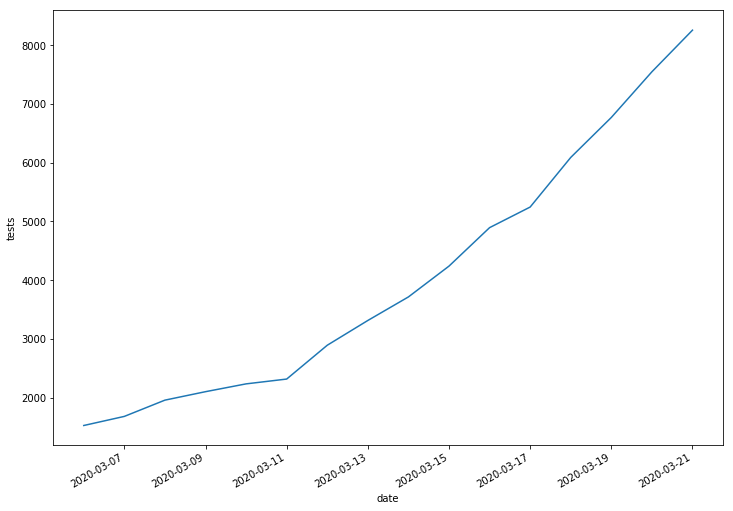

In [141]:
covid_dataset.tests.plot(figsize=(12,8))

In [106]:
print("Daily increase in number of test concluded")
all_results.tests.diff()[1:].astype('int')

Daily increase in number of test concluded


date
2020-03-07    155
2020-03-08    277
2020-03-09    144
2020-03-10    133
2020-03-11     82
2020-03-12    576
2020-03-13    422
2020-03-14    401
2020-03-15    525
2020-03-16    655
2020-03-17    351
2020-03-18    845
2020-03-19    681
2020-03-20    778
Name: Tests concluded, dtype: int32

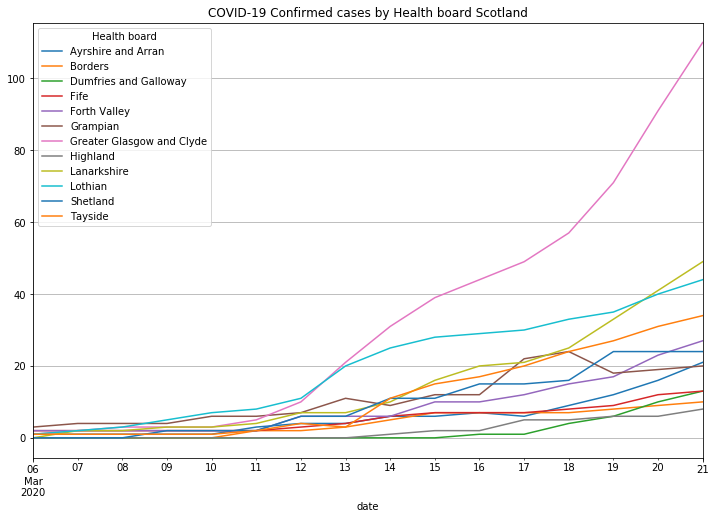

In [142]:
all_results.counts.plot(figsize=(12,8), title='COVID-19 Confirmed cases by Health board Scotland', grid=True)

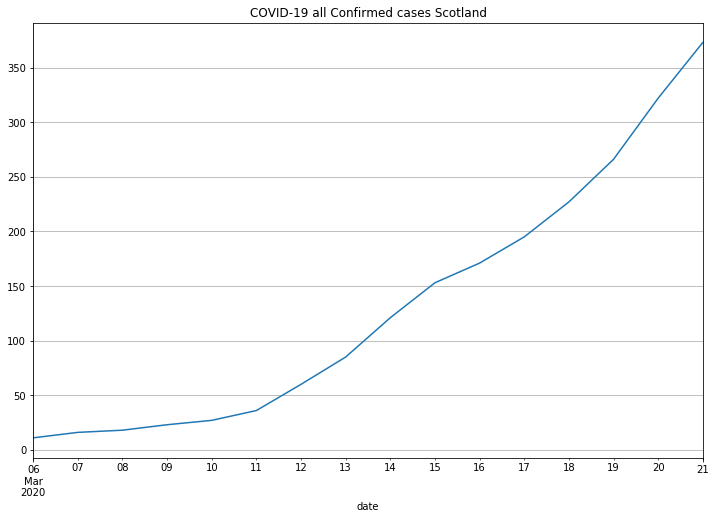

In [143]:
all_results.counts.sum(axis=1).plot(figsize=(12,8), title='COVID-19 all Confirmed cases Scotland', grid=True)

In [144]:
print("Daily increase of cases")
all_results.counts.sum(axis=1).diff()

Daily increase of cases


date
2020-03-06     NaN
2020-03-07     5.0
2020-03-08     2.0
2020-03-09     5.0
2020-03-10     4.0
2020-03-11     9.0
2020-03-12    24.0
2020-03-13    25.0
2020-03-14    36.0
2020-03-15    32.0
2020-03-16    18.0
2020-03-17    24.0
2020-03-18    32.0
2020-03-19    39.0
2020-03-20    56.0
2020-03-21    51.0
dtype: float64

In [145]:
print("% increase cases across Scotland")
round(all_results.counts.sum(axis=1).diff()/all_results.counts.sum(axis=1) * 100, 2)[1:]

% increase cases across Scotland


date
2020-03-07    31.25
2020-03-08    11.11
2020-03-09    21.74
2020-03-10    14.81
2020-03-11    25.00
2020-03-12    40.00
2020-03-13    29.41
2020-03-14    29.75
2020-03-15    20.92
2020-03-16    10.53
2020-03-17    12.31
2020-03-18    14.10
2020-03-19    14.66
2020-03-20    17.39
2020-03-21    13.67
dtype: float64

In [146]:
def calculate_percentage_increases(covid_data: pd.DataFrame) -> pd.DataFrame:
    """Approach gives 100% for first confirmed case, not ideal"""
    percentage_increases = []
    for index in range(1, len(covid_data)):
        percentage_increases.append(round(
            (covid_data.iloc[index] - covid_data.iloc[index - 1, :]) /covid_data.iloc[index, :] * 100 ,2))
    percentage_increases = pd.concat(percentage_increases, axis=1)
    percentage_increases.columns = covid_data.index[1:]
    percentage_increases.columns.name = 'Daily % increase'
    percentage_increases.index.name = 'Health Board'
    return percentage_increases

In [147]:
percentage_increases = calculate_percentage_increases(all_results.counts)
percentage_increases_numbers = percentage_increases.copy()
percentage_increases = percentage_increases.replace(100,'First Case Confirmed')
percentage_increases

Daily % increase,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21
Health Board,,,,,,,,,,,,,,,
Ayrshire and Arran,0,0.00,0,0.00,66.67,25.00,0.00,33.33,0.00,14.29,-16.67,33.33,25.00,25.00,23.81
Borders,NaN,NaN,NaN,NaN,First Case Confirmed,0.00,33.33,40,28.57,0,0.00,0.00,12.50,11.11,10.00
Dumfries and Galloway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,First Case Confirmed,0.00,75.00,33.33,40.00,23.08
Fife,0,0.00,0,0.00,0,33.33,25.00,33.33,14.29,0,0.00,12.50,11.11,25.00,7.69
Forth Valley,0,0.00,0,0.00,0,66.67,0.00,0,40.00,0,16.67,20.00,11.76,26.09,14.81
Grampian,25,0.00,0,33.33,0,14.29,36.36,-22.22,25.00,0,45.45,8.33,-33.33,5.26,5.00
Greater Glasgow and Clyde,50,33.33,0,0.00,40,50.00,52.38,32.26,20.51,11.36,10.20,14.04,19.72,21.98,17.27
Highland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,First Case Confirmed,50.00,0,60.00,0.00,16.67,0.00,25.00
Lanarkshire,First Case Confirmed,0.00,33.33,0.00,25,42.86,0.00,30,37.50,20,4.76,16.00,24.24,19.51,16.33


In [148]:
min_days_present = (~percentage_increases.isna()).sum(axis=1)
min_days_present.name = 'Minimum number of days of confirmed cases'
min_days_present

Health Board
Ayrshire and Arran           15
Borders                      11
Dumfries and Galloway         6
Fife                         15
Forth Valley                 15
Grampian                     15
Greater Glasgow and Clyde    15
Highland                      8
Lanarkshire                  15
Lothian                      15
Shetland                     13
Tayside                      15
Name: Minimum number of days of confirmed cases, dtype: int64

In [150]:
mean_daily_percent_increase_by_board = round(
    percentage_increases.mean(axis=1), 2)
mean_daily_percent_increase_by_board.name = "Mean % increase 6-21th March"
mean_daily_percent_increase_by_board.sort_values()

Health Board
Tayside                      10.78
Ayrshire and Arran           11.55
Shetland                     11.81
Borders                      11.94
Fife                         12.89
Grampian                     13.97
Lanarkshire                  16.12
Lothian                      18.46
Forth Valley                 19.60
Greater Glasgow and Clyde    23.94
Highland                     25.28
Dumfries and Galloway        34.28
Name: Mean % increase 6-21th March, dtype: float64

In [151]:
all_results

            Deaths of confirmed cases  Tests concluded
date                                                  
2020-03-06                          0             1525
2020-03-07                          0             1680
2020-03-08                          0             1957
2020-03-09                          0             2101
2020-03-10                          0             2234
2020-03-11                          0             2316
2020-03-12                          0             2892
2020-03-13                          1             3314
2020-03-14                          1             3715
2020-03-15                          1             4240
2020-03-16                          1             4895
2020-03-17                          2             5246
2020-03-18                          3             6091
2020-03-19                          6             6772
2020-03-20                          6             7550
2020-03-21                          7             8259